In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from scipy.sparse import hstack, csr_matrix

nltk.download("stopwords")
nltk.download("wordnet")


[nltk_data] Downloading package stopwords to C:\Users\Utsav
[nltk_data]     yadav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Utsav
[nltk_data]     yadav\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

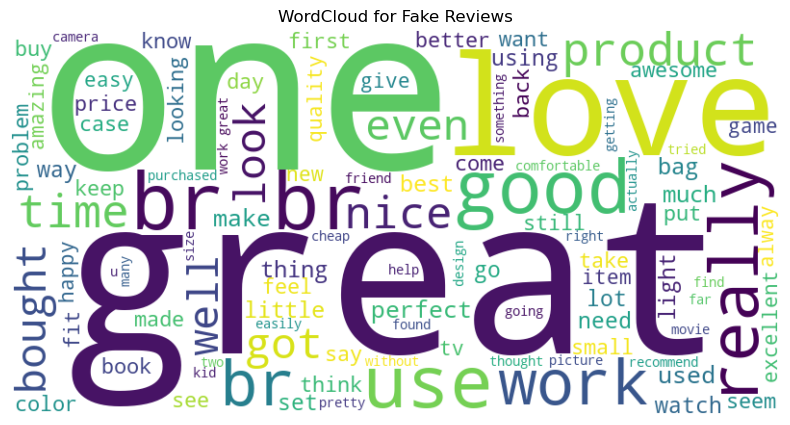

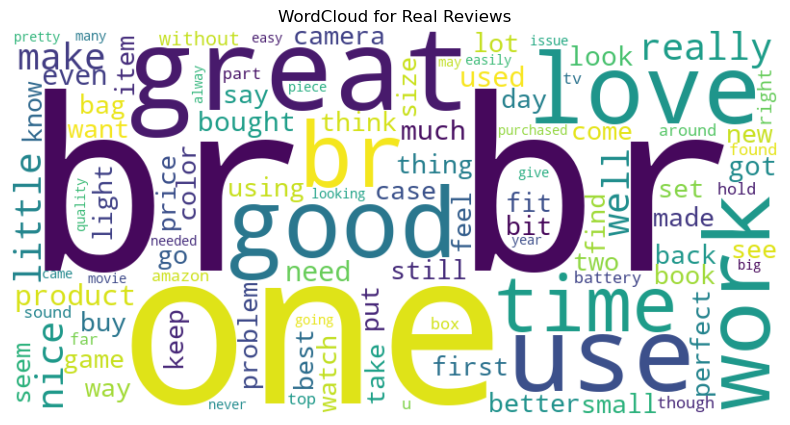

In [2]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return " ".join(tokens)

file_path = "amazon_reviews.txt"
df = pd.read_csv(file_path, sep="\t")

df.rename(columns={
    "LABEL": "target",
    "REVIEW_TITLE": "title",
    "REVIEW_TEXT": "text"
}, inplace=True)

df["combined"] = df["title"].fillna('') + " " + df["text"].fillna('')

df["target"] = df["target"].map({"__label1__": 0, "__label2__": 1})

df.dropna(subset=["combined", "target"], inplace=True)

df["cleaned_text"] = df["combined"].apply(clean_text)

df["RATING"] = pd.to_numeric(df["RATING"], errors="coerce")
df["verified_purchase"] = df["VERIFIED_PURCHASE"].map({"Y": 1, "N": 0})
df.dropna(subset=["RATING", "verified_purchase"], inplace=True)

fake_text = " ".join(df[df["target"] == 0]["cleaned_text"])
real_text = " ".join(df[df["target"] == 1]["cleaned_text"])

wc_fake = WordCloud(width=800, height=400, background_color="white",
                    stopwords=STOPWORDS, max_words=100).generate(fake_text)
plt.figure(figsize=(10, 5))
plt.imshow(wc_fake, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud for Fake Reviews")
plt.show()

wc_real = WordCloud(width=800, height=400, background_color="white",
                    stopwords=STOPWORDS, max_words=100).generate(real_text)
plt.figure(figsize=(10, 5))
plt.imshow(wc_real, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud for Real Reviews")
plt.show()



Best parameters for Logistic Regression: {'C': 1.5, 'max_iter': 1000}
Optimized Logistic Regression -- Accuracy: 0.7960, Precision: 0.7969
LogisticRegression -- Accuracy: 0.7960, Precision: 0.7969
RandomForest -- Accuracy: 0.8017, Precision: 0.8060
MultinomialNB -- Accuracy: 0.7698, Precision: 0.7728


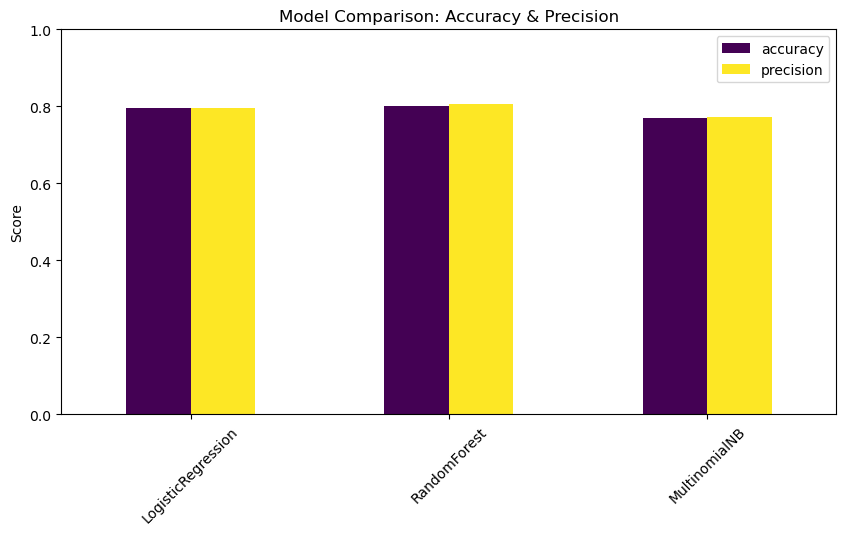

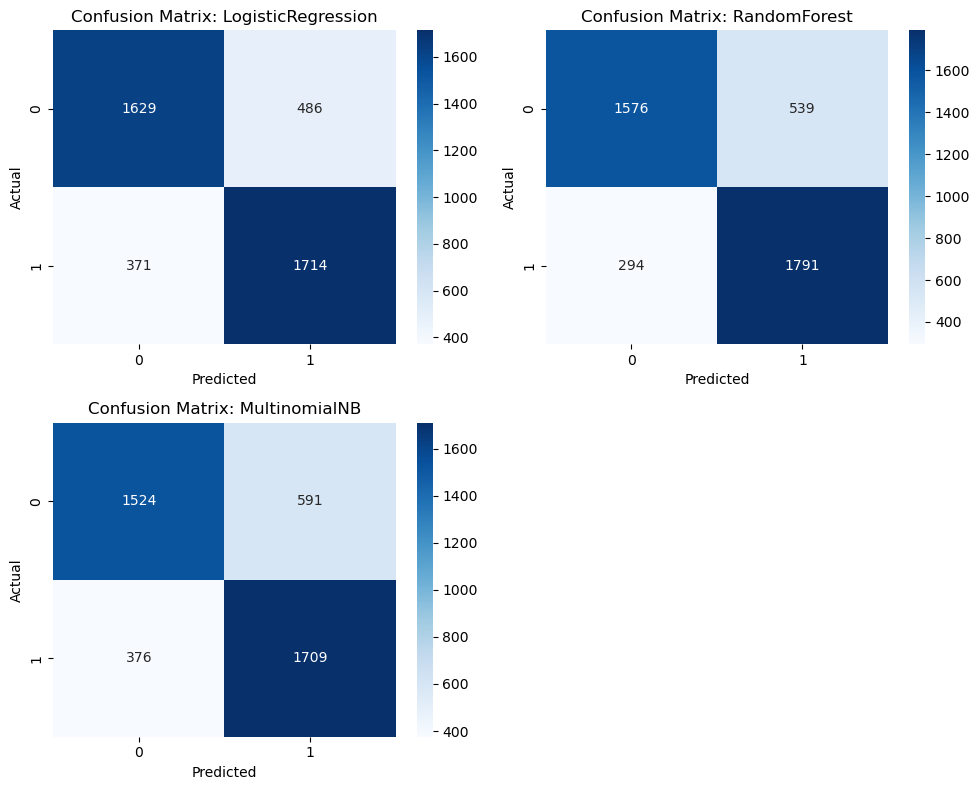

In [3]:
tfidf = TfidfVectorizer(max_features=6000, ngram_range=(1, 2), stop_words="english")
X_text = tfidf.fit_transform(df["cleaned_text"])

additional_features = df[["RATING", "verified_purchase"]].values
X_add = csr_matrix(additional_features)

X = hstack([X_text, X_add])

y = df["target"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'C': [0.1, 0.5, 1.0, 1.5, 2.0],
    'max_iter': [1000, 1500, 2000]
}
log_reg = LogisticRegression(solver='lbfgs')
grid_lr = GridSearchCV(log_reg, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train, y_train)
print("Best parameters for Logistic Regression:", grid_lr.best_params_)

best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr, average='weighted')
print("Optimized Logistic Regression -- Accuracy: {:.4f}, Precision: {:.4f}".format(acc_lr, prec_lr))

mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred_mnb = mnb.predict(X_test)
acc_mnb = accuracy_score(y_test, y_pred_mnb)
prec_mnb = precision_score(y_test, y_pred_mnb, average='weighted')

rf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, average='weighted')


results = {
    "LogisticRegression": {
        "accuracy": acc_lr,
        "precision": prec_lr,
        "conf_matrix": confusion_matrix(y_test, y_pred_lr)
    },
    "RandomForest": {
        "accuracy": acc_rf,
        "precision": prec_rf,
        "conf_matrix": confusion_matrix(y_test, y_pred_rf)
    },
    "MultinomialNB": {
        "accuracy": acc_mnb,
        "precision": prec_mnb,
        "conf_matrix": confusion_matrix(y_test, y_pred_mnb)
    }
}

for name, metrics in results.items():
    print(f"{name} -- Accuracy: {metrics['accuracy']:.4f}, Precision: {metrics['precision']:.4f}")

metrics_df = pd.DataFrame({
    name: {"accuracy": m["accuracy"], "precision": m["precision"]}
    for name, m in results.items()
}).T

metrics_df.plot(kind="bar", figsize=(10, 5), colormap="viridis")
plt.title("Model Comparison: Accuracy & Precision")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.show()

n_models = len(results)
n_cols = 2
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes = axes.flatten()

for ax, (name, metrics) in zip(axes, results.items()):
    sns.heatmap(metrics["conf_matrix"], annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"Confusion Matrix: {name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

# Hide any unused subplots
for ax in axes[len(results):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


In [9]:
import pickle

# Save the TF-IDF vectorizer (note: use transform for new reviews)
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

# Save the best logistic regression model
with open('best_lr_model.pkl', 'wb') as f:
    pickle.dump(best_lr, f)
